<a href="https://colab.research.google.com/github/Vishu254-bit/vish/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data split into training and testing sets.
Training set size: 6675 samples
Testing set size: 2862 samples
--------------------------------------------------
--- Training Decision Tree ---
Model: Decision Tree
  Accuracy: 0.8850
  Precision: 0.9027
  Recall: 0.8850
  F1-Score: 0.8822
  ROC AUC: 0.8732
--------------------------------------------------
--- Training KNN ---
Model: KNN
  Accuracy: 0.7970
  Precision: 0.8190
  Recall: 0.7970
  F1-Score: 0.7892
  ROC AUC: 0.8345
--------------------------------------------------
--- Training SVM ---
Model: SVM
  Accuracy: 0.8326
  Precision: 0.8426
  Recall: 0.8326
  F1-Score: 0.8292
  ROC AUC: 0.8612
--------------------------------------------------


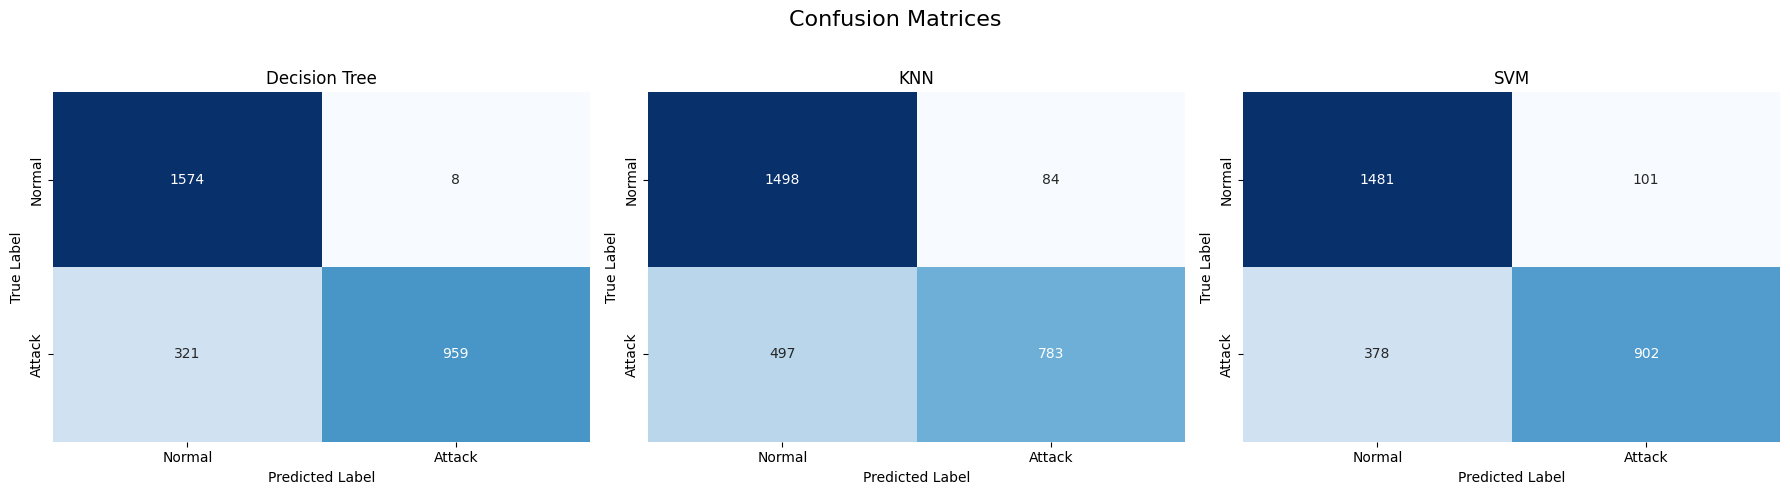

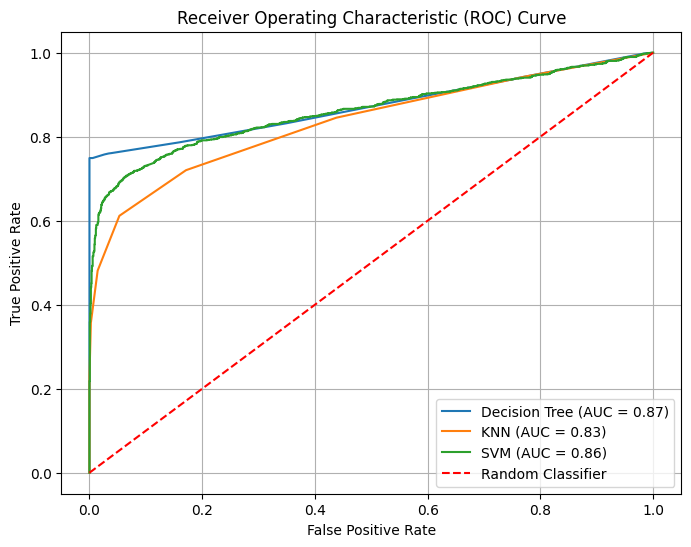

In [2]:
# =============================================================================
# Import Libraries
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# =============================================================================
# Load Dataset
# =============================================================================
# Load the dataset from the CSV file.
try:
    df = pd.read_csv('Cybersecurity Intrusion Detection(3).csv')
except FileNotFoundError:
    print("Error: The file 'Cybersecurity Intrusion Detection(3).csv' was not found.")
    exit()

# =============================================================================
# Data Preprocessing
# =============================================================================

# Separate features (X) and the target variable (y).
# The target variable is 'attack_detected'.
X = df.drop('attack_detected', axis=1)
y = df['attack_detected']

# Identify numerical and categorical columns for preprocessing.
# Based on the NSL-KDD dataset essay, we will one-hot encode
# categorical features and scale numerical ones.
numerical_cols = ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access']
categorical_cols = ['protocol_type', 'encryption_used', 'browser_type']

# Ensure the columns exist in the DataFrame.
for col in numerical_cols + categorical_cols:
    if col not in X.columns:
        print(f"Error: Column '{col}' not found in the dataset.")
        exit()

# Handle categorical features using one-hot encoding.
# This creates new binary columns for each category.
X_categorical = pd.get_dummies(X[categorical_cols], columns=categorical_cols, prefix=categorical_cols)

# Handle numerical features using MinMaxScaler.
# This scales all numerical features to a range of 0 to 1,
# which is crucial for distance-based algorithms like KNN and kernel-based SVM.
scaler = MinMaxScaler()
X_numerical = scaler.fit_transform(X[numerical_cols])
X_numerical = pd.DataFrame(X_numerical, columns=numerical_cols)

# Combine the preprocessed numerical and one-hot encoded categorical features.
X_processed = pd.concat([X_numerical, X_categorical], axis=1)

# Drop original columns to avoid data leakage and redundancy
X_processed = X_processed.drop(columns=['session_id'], errors='ignore')

# =============================================================================
# Train-Test Split
# =============================================================================
# Split the data into training and testing sets.
# A 70/30 split is used, with stratification to ensure the class distribution
# in the test set is similar to the training set.
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, stratify=y, random_state=42)

print("Data split into training and testing sets.")
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print("-" * 50)

# =============================================================================
# Model Implementation and Training
# =============================================================================

# Define the models with the hyperparameters specified in your essay.
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, metric='minkowski'),
    "SVM": SVC(kernel='rbf', C=10, gamma=0.1, random_state=42, probability=True)
}

# Dictionary to store performance metrics and predictions for plotting
results = {}

# Loop through each model, train it, and evaluate its performance.
for name, model in models.items():
    print(f"--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "cm": cm,
        "y_pred": y_pred,
    }

    # For ROC curve, we need the probability scores.
    # SVM with probability=True can be slower, but it's needed for ROC AUC.
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name]["fpr"] = fpr
        results[name]["tpr"] = tpr
        results[name]["auc"] = roc_auc
    else:
        results[name]["fpr"] = None
        results[name]["tpr"] = None
        results[name]["auc"] = None

    print(f"Model: {name}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if results[name]["auc"]:
        print(f"  ROC AUC: {results[name]['auc']:.4f}")
    print("-" * 50)

# =============================================================================
# Visualizations
# =============================================================================

# Plotting Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices', fontsize=16)

for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['Normal', 'Attack'])
    axes[i].set_yticklabels(['Normal', 'Attack'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plotting ROC Curves
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')

for name, res in results.items():
    if res['fpr'] is not None and res['tpr'] is not None:
        plt.plot(res['fpr'], res['tpr'], label=f'{name} (AUC = {res["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Data split into training and testing sets.
Training set size: 6675 samples
Testing set size: 2862 samples
--------------------------------------------------
--- Training Decision Tree ---
Model: Decision Tree
  Accuracy: 0.8850
  Precision: 0.9027
  Recall: 0.8850
  F1-Score: 0.8822
  ROC AUC: 0.8732
--------------------------------------------------
--- Training KNN ---
Model: KNN
  Accuracy: 0.7970
  Precision: 0.8190
  Recall: 0.7970
  F1-Score: 0.7892
  ROC AUC: 0.8345
--------------------------------------------------
--- Training SVM ---
Model: SVM
  Accuracy: 0.8326
  Precision: 0.8426
  Recall: 0.8326
  F1-Score: 0.8292
  ROC AUC: 0.8612
--------------------------------------------------


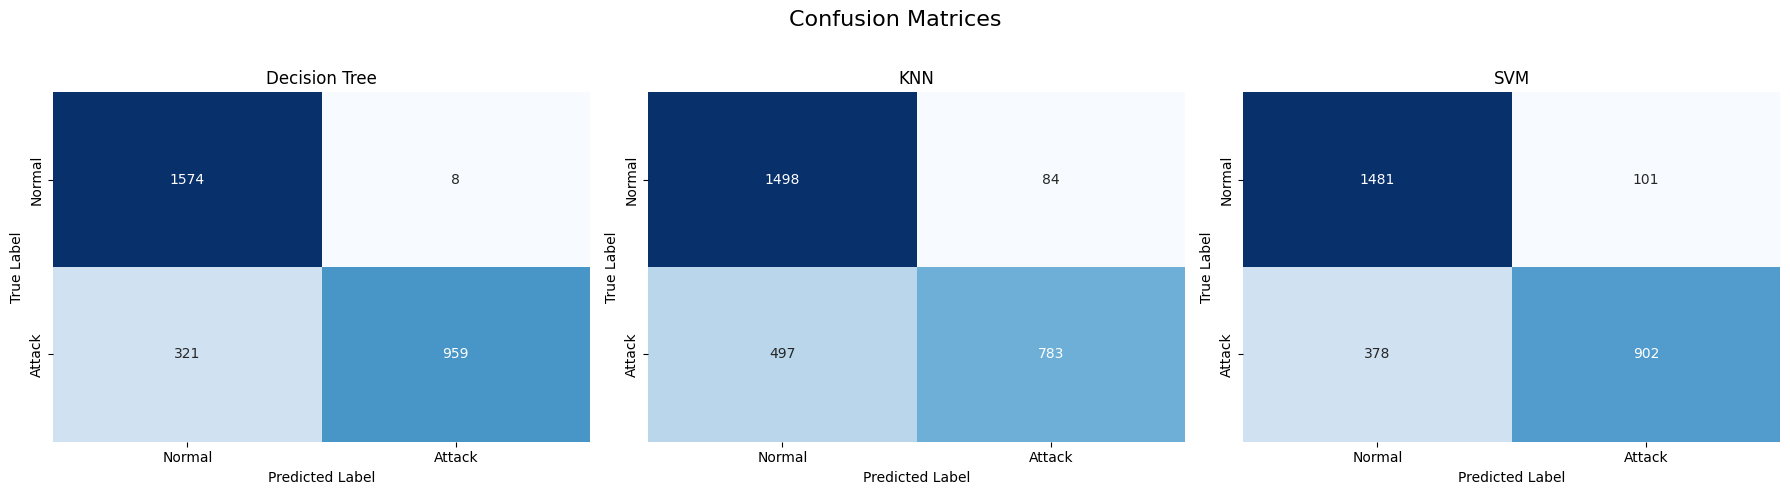

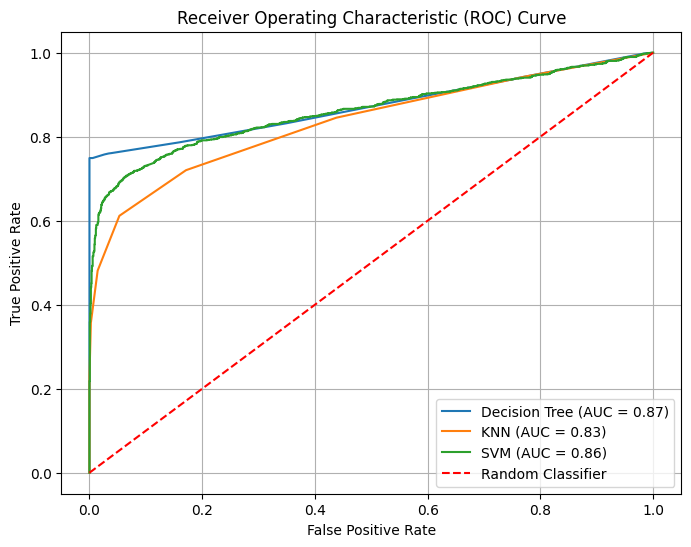

/tmp/ipython-input-3473746208.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=f1_scores, palette='viridis')


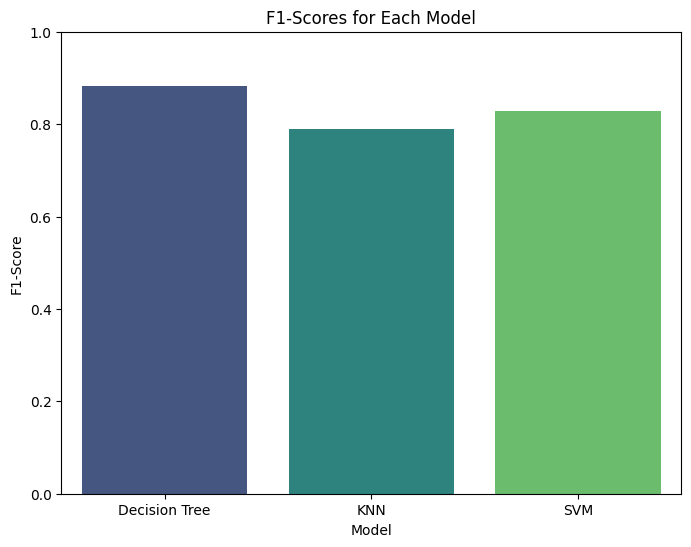

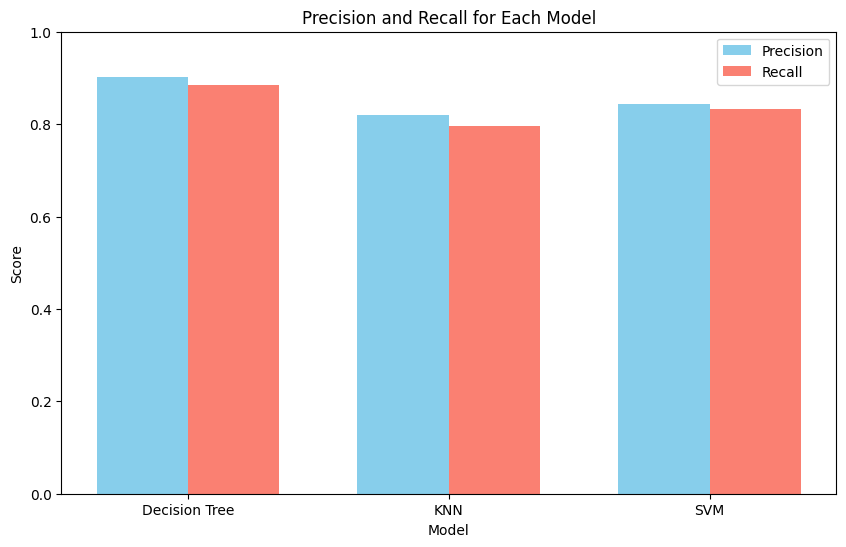

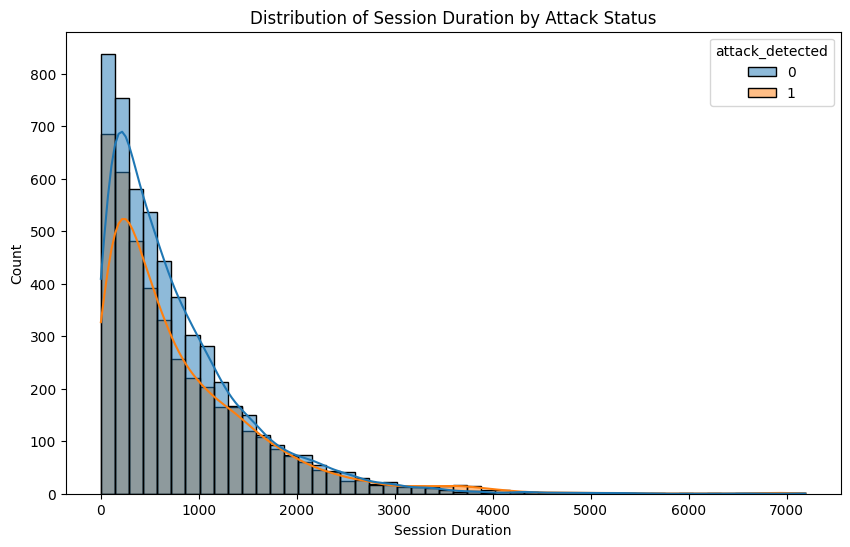

In [3]:
# =============================================================================
# Import Libraries
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# =============================================================================
# Load Dataset
# =============================================================================
# Load the dataset from the CSV file.
try:
    df = pd.read_csv('Cybersecurity Intrusion Detection(3).csv')
except FileNotFoundError:
    print("Error: The file 'Cybersecurity Intrusion Detection(3).csv' was not found.")
    exit()

# =============================================================================
# Data Preprocessing
# =============================================================================

# Separate features (X) and the target variable (y).
# The target variable is 'attack_detected'.
X = df.drop('attack_detected', axis=1)
y = df['attack_detected']

# Identify numerical and categorical columns for preprocessing.
# Based on the NSL-KDD dataset essay, we will one-hot encode
# categorical features and scale numerical ones.
numerical_cols = ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access']
categorical_cols = ['protocol_type', 'encryption_used', 'browser_type']

# Ensure the columns exist in the DataFrame.
for col in numerical_cols + categorical_cols:
    if col not in X.columns:
        print(f"Error: Column '{col}' not found in the dataset.")
        exit()

# Handle categorical features using one-hot encoding.
# This creates new binary columns for each category.
X_categorical = pd.get_dummies(X[categorical_cols], columns=categorical_cols, prefix=categorical_cols)

# Handle numerical features using MinMaxScaler.
# This scales all numerical features to a range of 0 to 1,
# which is crucial for distance-based algorithms like KNN and kernel-based SVM.
scaler = MinMaxScaler()
X_numerical = scaler.fit_transform(X[numerical_cols])
X_numerical = pd.DataFrame(X_numerical, columns=numerical_cols)

# Combine the preprocessed numerical and one-hot encoded categorical features.
X_processed = pd.concat([X_numerical, X_categorical], axis=1)

# Drop original columns to avoid data leakage and redundancy
X_processed = X_processed.drop(columns=['session_id'], errors='ignore')

# =============================================================================
# Train-Test Split
# =============================================================================
# Split the data into training and testing sets.
# A 70/30 split is used, with stratification to ensure the class distribution
# in the test set is similar to the training set.
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, stratify=y, random_state=42)

print("Data split into training and testing sets.")
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print("-" * 50)

# =============================================================================
# Model Implementation and Training
# =============================================================================

# Define the models with the hyperparameters specified in your essay.
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, metric='minkowski'),
    "SVM": SVC(kernel='rbf', C=10, gamma=0.1, random_state=42, probability=True)
}

# Dictionary to store performance metrics and predictions for plotting
results = {}

# Loop through each model, train it, and evaluate its performance.
for name, model in models.items():
    print(f"--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "cm": cm,
        "y_pred": y_pred,
    }

    # For ROC curve, we need the probability scores.
    # SVM with probability=True can be slower, but it's needed for ROC AUC.
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name]["fpr"] = fpr
        results[name]["tpr"] = tpr
        results[name]["auc"] = roc_auc
    else:
        results[name]["fpr"] = None
        results[name]["tpr"] = None
        results[name]["auc"] = None

    print(f"Model: {name}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if results[name]["auc"]:
        print(f"  ROC AUC: {results[name]['auc']:.4f}")
    print("-" * 50)

# =============================================================================
# Visualizations
# =============================================================================

# Plotting Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices', fontsize=16)

for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['Normal', 'Attack'])
    axes[i].set_yticklabels(['Normal', 'Attack'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plotting ROC Curves
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')

for name, res in results.items():
    if res['fpr'] is not None and res['tpr'] is not None:
        plt.plot(res['fpr'], res['tpr'], label=f'{name} (AUC = {res["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plotting F1-Scores
plt.figure(figsize=(8, 6))
f1_scores = [results[name]['f1'] for name in models]
model_names = list(models.keys())
sns.barplot(x=model_names, y=f1_scores, palette='viridis')
plt.title('F1-Scores for Each Model')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()

# Plotting Precision and Recall
plt.figure(figsize=(10, 6))
precision_scores = [results[name]['precision'] for name in models]
recall_scores = [results[name]['recall'] for name in models]
x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, precision_scores, width, label='Precision', color='skyblue')
plt.bar(x + width/2, recall_scores, width, label='Recall', color='salmon')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Precision and Recall for Each Model')
plt.xticks(x, model_names)
plt.legend()
plt.ylim(0, 1)
plt.show()

# Plotting a distribution of 'session_duration' for attack vs normal traffic
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='session_duration', hue='attack_detected', kde=True, bins=50)
plt.title('Distribution of Session Duration by Attack Status')
plt.xlabel('Session Duration')
plt.ylabel('Count')
plt.show()
